#  Classification des documents avec des caractéristiques textuelles et structurelles

In [1]:
# Imports des bibliothèques et modules nécessaires
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
import time

import warnings
warnings.filterwarnings("ignore")
# Ajouter le répertoire parent au chemin de recherche
sys.path.append(os.path.abspath('..'))

# Import des modules du projet
from src.config.config import load_config
from src.data_acquisition.data_loader import DataLoader
from src.classification.classifier import Classifier
from src.classification.evaluator import Evaluator
from src.classification.feature_extractor import FeatureExtractor
from src.search_engine.indexer import Indexer

## 1. Chargement des données prétraitées

In [2]:
# Charger la configuration
config = load_config()

# Chemin vers le fichier de données prétraitées
processed_data_path = Path("../data/processed/corpus_preprocessed.json")

# Vérifier si le fichier existe
if not processed_data_path.exists():
    raise FileNotFoundError(f"Le fichier {processed_data_path} n'existe pas.")

# Créer un objet DataLoader
data_loader = DataLoader(config)

# Charger les données
cleaned_docs = data_loader.load_from_json(processed_data_path)

# Filtrer les documents ayant un abstract non vide et au moins une citation
filtered_docs = [doc for doc in cleaned_docs if doc.get("abstract", "").strip() != "" and doc.get("references", [])]

# Limiter aux n premiers articles si besoin
filtered_docs = filtered_docs

# Afficher un aperçu des données filtrées
pd.DataFrame(filtered_docs).head()

,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,purpose develop tool high school student study...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,international conference on human-computer int...,purpose develop tool high school student study...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
2,visual analytics science and technology,describes implementation methodology visualisa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
3,visual analytics science and technology,describes implementation methodology visualisa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
4,pattern recognition and machine intelligence,article applied garch instead ar arma compare ...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4


## 2. Préparation des données pour la classification
( Cette section a été enrichie de prints systématiques sur l'avancement du process, ceci a permis de débugger quelques blocages recalcitrants dans la logique )

In [3]:
# Créer un indexeur et construire l'index TF-IDF
print("[INFO] Initialisation de l'indexeur...")
indexer = Indexer(config)

print("[INFO] Construction de l'index TF-IDF à partir des abstracts...")
start_time = time.time()
index_stats = indexer.build_index(filtered_docs, content_field='abstract')  # Utilisez filtered_docs
index_time = time.time() - start_time
print(f"[INFO] Index construit en {index_time:.2f} secondes")
print(f"[INFO] Statistiques de l'index: {len(indexer.document_ids)} documents, {indexer.tfidf_matrix.shape[1]} termes")

# Créer un graphe de citation
from src.graph_analysis.graph_builder import GraphBuilder

print("[INFO] Initialisation du constructeur de graphe...")
graph_builder = GraphBuilder(filtered_docs)  # Utilisez filtered_docs

print("[INFO] Construction du graphe de citation...")
start_time = time.time()
citation_graph = graph_builder.build_citation_graph()
graph_time = time.time() - start_time
print(f"[INFO] Graphe construit en {graph_time:.2f} secondes")
print(f"[INFO] Statistiques du graphe: {citation_graph.number_of_nodes()} nœuds, {citation_graph.number_of_edges()} arêtes")

# Initialiser l'extracteur de caractéristiques avec limitation de dimensions
print("[INFO] Initialisation de l'extracteur de caractéristiques...")
feature_extractor = FeatureExtractor(
    indexer=indexer,
    graph=citation_graph,
    max_features=500,  # Limiter le nombre de caractéristiques maximal
    feature_selection='svd'  # Utiliser SVD pour la réduction de dimension
)
print("[INFO] Extracteur de caractéristiques initialisé")

# Extraire les ID des documents et leurs labels
print("[INFO] Extraction des IDs de documents et des étiquettes...")
doc_ids = [doc["id"] for doc in filtered_docs]  # Utilisez filtered_docs
labels = [doc.get("class", "unknown") for doc in filtered_docs]  # Utilisez filtered_docs
print(f"[INFO] {len(doc_ids)} documents avec étiquettes extraits")

# Afficher la distribution des classes
class_distribution = pd.Series(labels).value_counts()
print("[INFO] Distribution des classes:")
for cls, count in class_distribution.items():
    print(f"  - Classe '{cls}': {count} documents ({count/len(labels)*100:.1f}%)")

# Séparer en jeu d'entraînement et de test
print("[INFO] Division en ensembles d'entraînement (80%) et de test (20%)...")
doc_ids_train, doc_ids_test, labels_train, labels_test = train_test_split(
    doc_ids, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"[INFO] Ensemble d'entraînement: {len(doc_ids_train)} documents")
print(f"[INFO] Ensemble de test: {len(doc_ids_test)} documents")

[INFO] Initialisation de l'indexeur...
[INFO] Construction de l'index TF-IDF à partir des abstracts...
[INFO] Index construit en 3.87 secondes
[INFO] Statistiques de l'index: 32290 documents, 14693 termes
[INFO] Initialisation du constructeur de graphe...
[INFO] Construction du graphe de citation...
Graphe construit avec 16145 nœuds et 1564 arêtes.
[INFO] Graphe construit en 0.24 secondes
[INFO] Statistiques du graphe: 16145 nœuds, 1564 arêtes
[INFO] Initialisation de l'extracteur de caractéristiques...
[INFO] FeatureExtractor initialisé avec max_features=500, méthode=svd
[INFO] Extracteur de caractéristiques initialisé
[INFO] Extraction des IDs de documents et des étiquettes...
[INFO] 32290 documents avec étiquettes extraits
[INFO] Distribution des classes:
  - Classe '1': 9222 documents (28.6%)
  - Classe '2': 5252 documents (16.3%)
  - Classe '7': 3686 documents (11.4%)
  - Classe '8': 3648 documents (11.3%)
  - Classe '5': 3518 documents (10.9%)
  - Classe '6': 2704 documents (8.4%

## 3. Protocole expérimental complet (training, prédiction, évaluation) d'un combinaison de modèles et de caractéristiques

Cette partie fait un pipe complet d'entrainement-évaluation d'une combinaison de modèles et de caractéristiques. Ce sont les résultats de cette section qui sont présentés dans le rapport.

In [5]:
# Configuration des modèles et caractéristiques d'entrée possibles
models = ['lr', 'rf']
configs = [
    {'name': 'Texte uniquement (TF-IDF)', 'text': True, 'graph': False, 'tfidf': True},
    {'name': 'Graphe uniquement', 'text': False, 'graph': True, 'tfidf': False},
    {'name': 'Texte (TF-IDF) + Graphe', 'text': True, 'graph': True, 'tfidf': True}
]

# Instancier l'objet classifieur
classifier = Classifier(feature_extractor)

# Préparer un tableau pour stocker les résultats
results_data = []

# Tester chaque combinaison
for model in models:
    for config in configs:
        print(f"\n[INFO] Test du modèle {model.upper()} avec configuration {config['name']}...")

        # Entraîner le modèle avec cette configuration
        result = classifier.train_classifier(
            doc_ids=doc_ids_train,
            labels=labels_train,
            classifier_type=model,
            use_text_features=config['text'],
            use_graph_features=config['graph'],
            use_tfidf=config['tfidf'],
            test_size=0.2,
            cross_validation=True
        )

        # Stocker les résultats
        results_data.append({
            'Modèle': model.upper(),
            'Configuration': config['name'],
            'Accuracy': result['accuracy'],
            'CV moyenne': result.get('cv_mean', None),
            'Temps d\'entraînement (s)': result['training_time']
        })

# Créer un DataFrame avec les résultats
comparison_df = pd.DataFrame(results_data)
print("\n[INFO] Tableau comparatif des performances:")
print(comparison_df)

[INFO] Classifier initialisé avec le FeatureExtractor

[INFO] Test du modèle LR avec configuration Texte uniquement (TF-IDF)...
[INFO] Début de l'entraînement du classificateur de type 'lr'...
[INFO] Configuration - texte: True, graphe: False, tfidf: True
[INFO] Encodage des étiquettes...
[INFO] Classes détectées: 8 (1, 2, 3, 4, 5, 6, 7, 8)
[INFO] Extraction des caractéristiques textuelles pour 25832 documents...
[INFO] Début de l'extraction des caractéristiques textuelles pour 25832 documents...
[INFO] Récupération des indices de documents...
[INFO] 25832 documents trouvés dans l'index
[INFO] Utilisation de la matrice TF-IDF de taille (32290, 14693)
[INFO] Extraction des caractéristiques...
[INFO] Conversion de la matrice sparse en array dense
[INFO] Caractéristiques extraites : (25832, 14693) (documents × termes)
[INFO] Réduction des dimensions de 14693 à 500 caractéristiques...
[INFO] Application de la transformation existante...
[INFO] Transformation appliquée en 2.70s
[INFO] Extra

## 4. Code pour exploitation de diverses fonctionnalités du module

Cette partie, contrairement à la précédente, découpe en parties distinctes les différentes étapes, afin de faire une démonstration de l'utilisation des différentes fonctionnalités.

### 4.1. Entrainer un classificateur

In [6]:
print("[INFO] Initialisation du classificateur...")
classifier = Classifier(feature_extractor)

# Entraîner un classificateur avec des caractéristiques textuelles et de graphe
print("[INFO] Configuration du processus d'entraînement...")
print("[INFO] Type de modèle: Régression logistique")
print("[INFO] Caractéristiques: textuelles (TF-IDF) + graphe")

start_time = time.time()
print("[INFO] Démarrage de l'entraînement...")

# L'entraînement avec le nouveau classifier retourne les résultats d'évaluation
results = classifier.train_classifier(
    doc_ids_train,
    labels_train,
    classifier_type='rf',  # Régression logistique
    use_graph_features=True,
    use_text_features=True,
    use_tfidf=True,
    test_size=0.2,  # Validation interne sur 20% des données d'entraînement
    cross_validation=True  # Activer la validation croisée
)

train_time = time.time() - start_time
print(f"[INFO] Entraînement terminé en {train_time:.2f} secondes")

# Afficher un résumé des résultats
print(f"\n[INFO] Résumé des performances:")
print(f"  - Précision sur la validation: {results['accuracy']:.4f}")
if 'cv_mean' in results:
    print(f"  - Précision moyenne en validation croisée: {results['cv_mean']:.4f} (±{results['cv_std']:.4f})")

# Afficher les performances par classe si disponible
if 'classification_report' in results:
    print("\n[INFO] Rapport de classification:")
    # Vérifier si le rapport est une chaîne ou un dictionnaire
    if isinstance(results['classification_report'], str):
        print(results['classification_report'])
    else:
        # C'est un dictionnaire
        for class_name, metrics in results['classification_report'].items():
            if isinstance(metrics, dict) and 'precision' in metrics:
                print(f"  - Classe '{class_name}':")
                print(f"      Précision: {metrics['precision']:.4f}")
                print(f"      Rappel: {metrics['recall']:.4f}")
                print(f"      F1-score: {metrics['f1-score']:.4f}")
                print(f"      Support: {metrics['support']}")

# Afficher la matrice de confusion si disponible
if 'confusion_matrix' in results:
    print("\n[INFO] Matrice de confusion:")
    print(results['confusion_matrix'])

[INFO] Initialisation du classificateur...
[INFO] Classifier initialisé avec le FeatureExtractor
[INFO] Configuration du processus d'entraînement...
[INFO] Type de modèle: Régression logistique
[INFO] Caractéristiques: textuelles (TF-IDF) + graphe
[INFO] Démarrage de l'entraînement...
[INFO] Début de l'entraînement du classificateur de type 'rf'...
[INFO] Configuration - texte: True, graphe: True, tfidf: True
[INFO] Encodage des étiquettes...
[INFO] Classes détectées: 8 (1, 2, 3, 4, 5, 6, 7, 8)
[INFO] Extraction des caractéristiques textuelles pour 25832 documents...
[INFO] Début de l'extraction des caractéristiques textuelles pour 25832 documents...
[INFO] Récupération des indices de documents...
[INFO] 25832 documents trouvés dans l'index
[INFO] Utilisation de la matrice TF-IDF de taille (32290, 14693)
[INFO] Extraction des caractéristiques...
[INFO] Conversion de la matrice sparse en array dense
[INFO] Caractéristiques extraites : (25832, 14693) (documents × termes)
[INFO] Réduction

## 4.2 Prédictions sur un jeu de test

[INFO] Démarrage de la prédiction sur l'ensemble de test...
[INFO] Prédiction pour 6458 documents...
[INFO] Extraction des caractéristiques textuelles...
[INFO] Début de l'extraction des caractéristiques textuelles pour 6458 documents...
[INFO] Récupération des indices de documents...
[INFO] 6458 documents trouvés dans l'index
[INFO] Utilisation de la matrice TF-IDF de taille (32290, 14693)
[INFO] Extraction des caractéristiques...
[INFO] Conversion de la matrice sparse en array dense
[INFO] Caractéristiques extraites : (6458, 14693) (documents × termes)
[INFO] Réduction des dimensions de 14693 à 500 caractéristiques...
[INFO] Application de la transformation existante...
[INFO] Transformation appliquée en 0.67s
[INFO] Extraction et réduction terminées en 5.88 secondes
[INFO] Dimensions finales: (6458, 500) (documents × caractéristiques)
[INFO] Extraction des caractéristiques de graphe...
[INFO] Début de l'extraction des caractéristiques de graphe pour 6458 nœuds...
[INFO] Graphe dispo

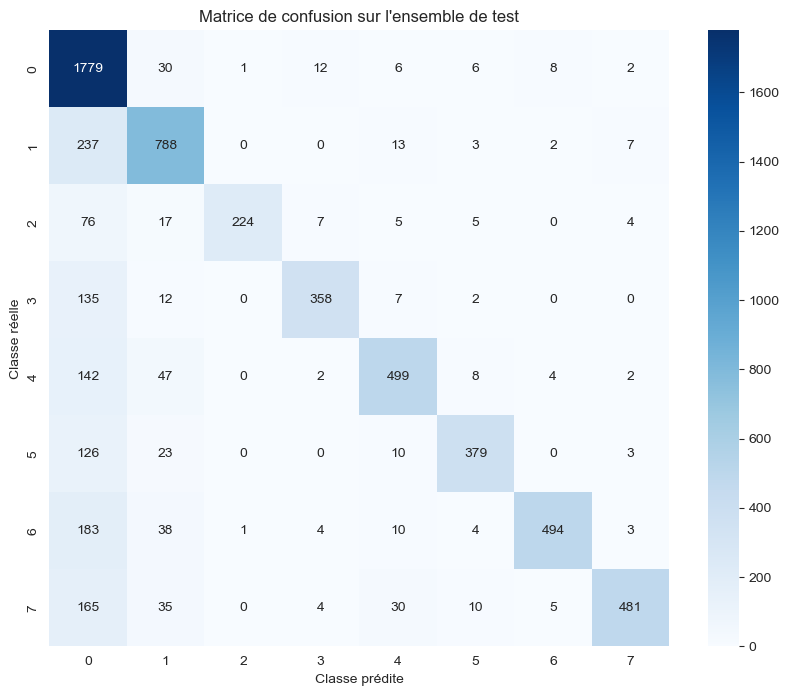

[INFO] Analyse des erreurs de classification...
[INFO] Nombre d'erreurs: 1456 sur 6458 documents (taux d'erreur: 22.55%)
[INFO] Exemples d'erreurs:
  Erreur 1:
    - ID document: 0fc50eb2-0e40-4d4d-975d-3244ac6188a6
    - Classe réelle: 7
    - Classe prédite: 1
    - Titre: Parallel simulation of urban dynamics on the GPU
    - Résumé (extrait): recent year geosimulation becoming increasingly sophisticated applied realworld covering large geographical area often require extended computing spit...

  Erreur 2:
    - ID document: 66f4783c-e7f2-4ccb-9f0c-f2c68a6f00e0
    - Classe réelle: 1
    - Classe prédite: 5
    - Titre: Information extraction from webpages based on DOM distances
    - Résumé (extrait): retrieving internet difficult demonstrated lack realtime tool able extract webpage main cause webpage internet implemented plain xhtml lack structured...

  Erreur 3:
    - ID document: 67c54ea8-4b05-4098-80c3-32f5514fbc5c
    - Classe réelle: 8
    - Classe prédite: 1
    - Titre: R

In [7]:
# Prédire les classes des documents de test
print("[INFO] Démarrage de la prédiction sur l'ensemble de test...")
start_time = time.time()

predictions = classifier.predict(
    doc_ids_test,
    use_graph_features=True,
    use_text_features=True,
    use_tfidf=True
)

prediction_time = time.time() - start_time
print(f"[INFO] Prédictions terminées en {prediction_time:.2f} secondes pour {len(doc_ids_test)} documents")

# Évaluer les performances
print("[INFO] Évaluation des performances sur l'ensemble de test...")
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer la précision
accuracy = accuracy_score(labels_test, predictions)
print(f"[INFO] Précision sur l'ensemble de test: {accuracy:.4f}")

# Générer le rapport de classification détaillé
report = classification_report(labels_test, predictions, output_dict=True)
print("[INFO] Rapport de classification:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and 'precision' in metrics:
        print(f"  - Classe '{class_name}':")
        print(f"      Précision: {metrics['precision']:.4f}")
        print(f"      Rappel: {metrics['recall']:.4f}")
        print(f"      F1-score: {metrics['f1-score']:.4f}")
        print(f"      Support: {metrics['support']}")

# Afficher le rapport de classification global
print(f"[INFO] Performances globales:")
print(f"  - Précision moyenne (macro): {report['macro avg']['precision']:.4f}")
print(f"  - Rappel moyen (macro): {report['macro avg']['recall']:.4f}")
print(f"  - F1-score moyen (macro): {report['macro avg']['f1-score']:.4f}")
print(f"  - Précision moyenne (pondérée): {report['weighted avg']['precision']:.4f}")
print(f"  - F1-score moyen (pondéré): {report['weighted avg']['f1-score']:.4f}")

# Visualiser la matrice de confusion
cm = confusion_matrix(labels_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion sur l\'ensemble de test')
plt.show()

# Vérifier les erreurs
print("[INFO] Analyse des erreurs de classification...")
errors = [(i, true, pred) for i, (true, pred) in enumerate(zip(labels_test, predictions)) if true != pred]
print(f"[INFO] Nombre d'erreurs: {len(errors)} sur {len(labels_test)} documents (taux d'erreur: {len(errors)/len(labels_test):.2%})")

if len(errors) > 0:
    print("[INFO] Exemples d'erreurs:")
    for i, (idx, true, pred) in enumerate(errors[:5]):  # Afficher les 5 premières erreurs
        doc_id = doc_ids_test[idx]
        doc = next((d for d in filtered_docs if d['id'] == doc_id), None)
        if doc:
            print(f"  Erreur {i+1}:")
            print(f"    - ID document: {doc_id}")
            print(f"    - Classe réelle: {true}")
            print(f"    - Classe prédite: {pred}")
            if 'title' in doc:
                print(f"    - Titre: {doc['title']}")
            abstract = doc.get('abstract', '')
            if abstract:
                print(f"    - Résumé (extrait): {abstract[:150]}...")
            print()

### 4.3 Évaluation des performances d'un modèle

[INFO] Evaluator initialisé
[INFO] Évaluation des performances du classificateur...
[INFO] Nombre d'échantillons: 6458
[INFO] Calcul des métriques de classification...
[INFO] Accuracy globale: 0.7745
[INFO] F1-score macro: 0.7826
[INFO] F1-score pondéré: 0.7767
[INFO] Évaluation terminée en 0.20 secondes
Rapport de classification :
              precision    recall  f1-score   support

           1       0.63      0.96      0.76      1844
           2       0.80      0.75      0.77      1050
           3       0.99      0.66      0.79       338
           4       0.93      0.70      0.79       514
           5       0.86      0.71      0.78       704
           6       0.91      0.70      0.79       541
           7       0.96      0.67      0.79       737
           8       0.96      0.66      0.78       730

    accuracy                           0.77      6458
   macro avg       0.88      0.73      0.78      6458
weighted avg       0.82      0.77      0.78      6458



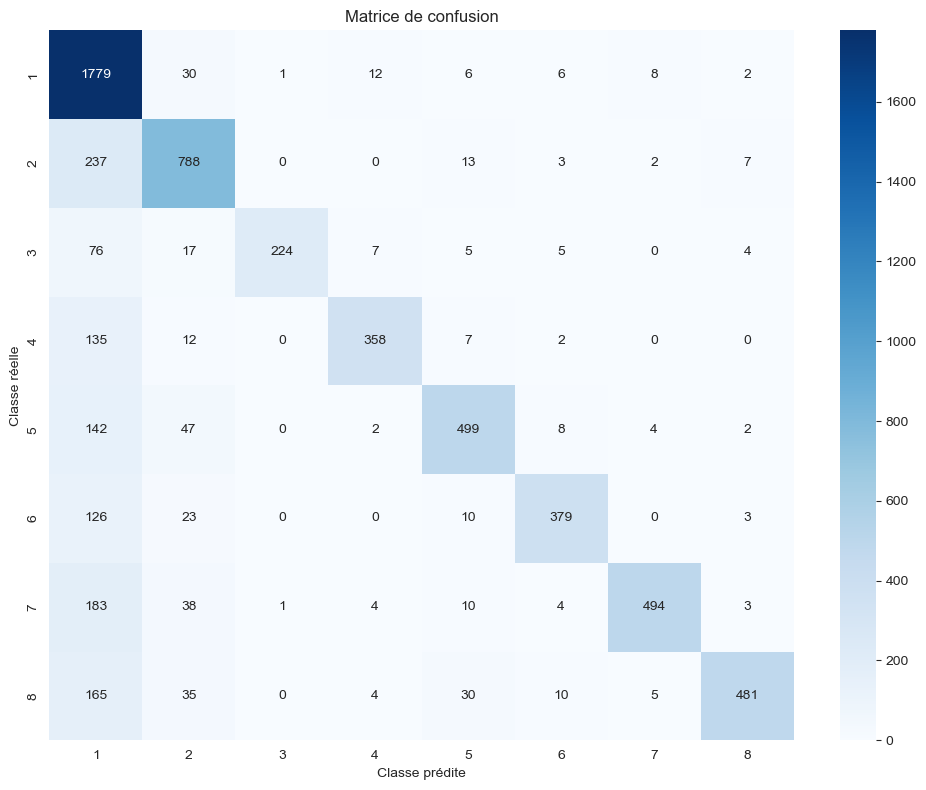

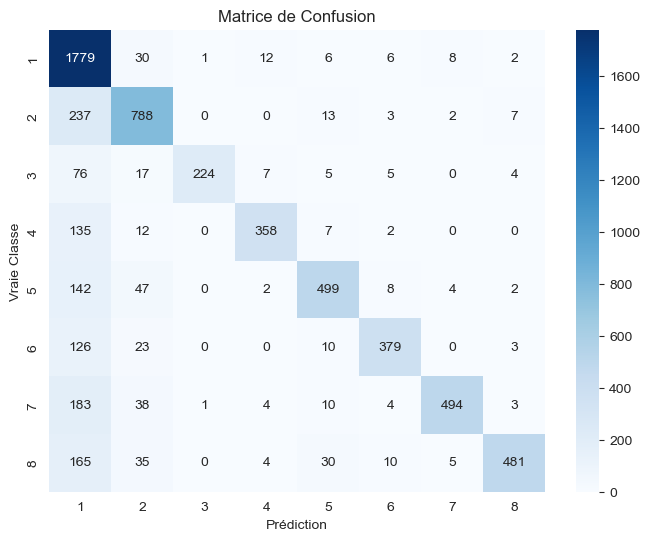

In [8]:
# Initialiser l'évaluateur
evaluator = Evaluator()

# Évaluer la classification
results = evaluator.evaluate_classifier(labels_test, predictions)

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(labels_test, predictions))

# Afficher la matrice de confusion
conf_matrix = results['confusion_matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(labels), yticklabels=set(labels))
plt.xlabel("Prédiction")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion")
plt.show()